In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [56]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res


NameError: name 'analysis_master_path' is not defined

# Set experiment(s) to analyze


In [20]:
exp_ids=['2018_04_25_11_08_57_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.25',
         '2018_04_25_11_50_27_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.125',
         '2018_04_25_12_26_37_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.0625',
         '2018_04_25_12_14_25_Rydberg 780A TPS, 780A 50mV, shimZ_OP=0.0625',
         '2018_04_25_12_47_10_Rydberg 780A TPS, 780A 50mV, shimZ_OP=+0.25'
        ]

assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_25/2018_04_25_11_08_57_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.25/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_25/2018_04_25_11_50_27_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.125/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_25/2018_04_25_12_26_37_Rydberg 780A TPS, 780A 50mV, shimZ_OP=-0.0625/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_25/2018_04_25_12_14_25_Rydberg 780A TPS, 780A 50mV, shimZ_OP=0.0625/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_04_25/2018_04_25_12_47_10_Rydberg 780A TPS, 780A 50mV, shimZ_OP=+0.25/qdp.txt


# Experiment-wise analysis

<IPython.core.display.Javascript object>


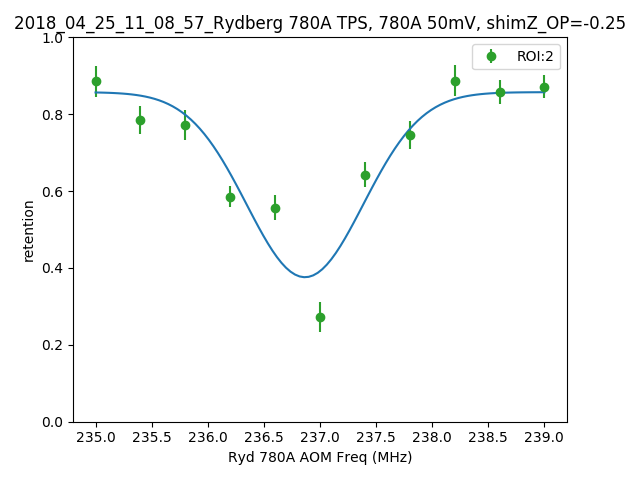

amplitude: -0.481406280706 , x0: 236.865802609, sigma:0.735227941304 


<IPython.core.display.Javascript object>


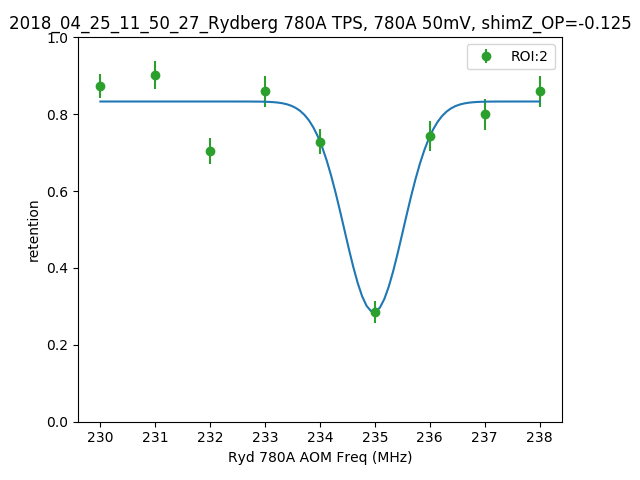

amplitude: -0.547728325096 , x0: 234.979724545, sigma:0.760410001481 


<IPython.core.display.Javascript object>


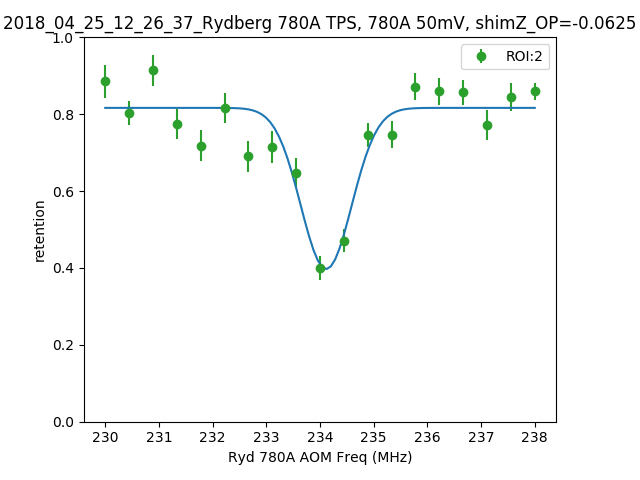

amplitude: -0.419303841907 , x0: 234.116120637, sigma:0.669889672142 


<IPython.core.display.Javascript object>


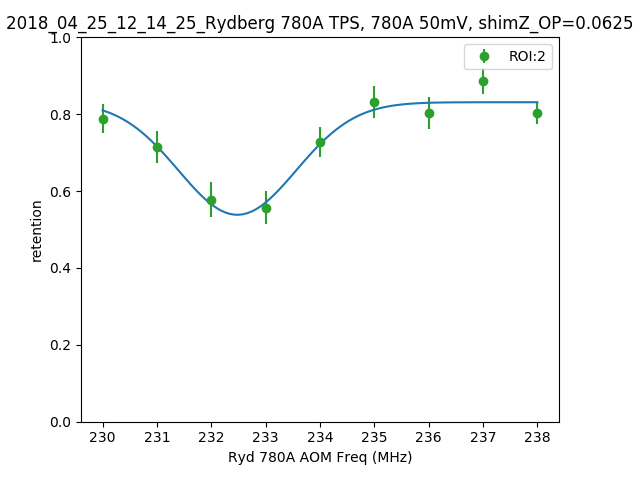

amplitude: -0.292846832705 , x0: 232.479056986, sigma:1.52877981594 


<IPython.core.display.Javascript object>


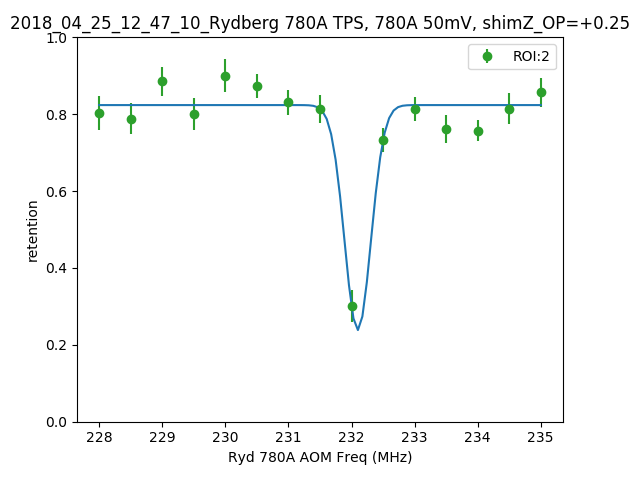

amplitude: -0.585327715611 , x0: 232.0982798, sigma:0.294775814573 


In [35]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
savefig=False
for i in range(0,len(exp_ids)):
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()

    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[-0.4, 233, 2 , 0.9]
    fitted_parameters=[]
    for roi in [2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        try:
            fit,pcov = curve_fit(gaussian,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
        except RuntimeError:
            error=1
        if error is not 1:
            print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
 
            xarray=np.linspace(np.min(data),np.max(data),100)
            yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
            plt.plot(xarray,yfit)
            if roi==2:
                assorted_roi2freqs.append(fit[1])

    plt.show()
    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig('{}.pdf'.format(exp_id))

In [46]:
def quadratic(x,A,x0,y0):
    res=y0+A*(x-x0)**2
    return res

def linear(x,A,x0,y0):
    res=y0+A*(x-x0)
    return res

Zcurrent=np.array([-0.25,-0.125,-0.0625,0.0625,0.25])
calibration=-9.715 # Gauss per amps
Bz=calibration*Zcurrent
#TokHz=1000.0
ydata=np.array(assorted_roi2freqs)
# yerror=TokHz*np.array(assorted_roi2perr)
fig, ax=plt.subplots()
ax.scatter(Bz,ydata)
fit_guesses=[-2.2,0,234]
fit,pcov = curve_fit(linear,Bz,ydata,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
xarray=np.linspace(np.min(Bz),np.max(Bz),100)
yfit=linear(xarray,fit[0],fit[1],fit[2])
ax.plot(xarray,yfit)
print 'A:{}, x0:{}, y0:{}'.format(fit[0],fit[1],fit[2])

<IPython.core.display.Javascript object>

ValueError: x and y must be the same size

In [93]:
print c*-0.25
print c*-0.45
print c*-0.125
    

-2.42885317967
-4.37193572341
-1.21442658984


# Trying Stark-map style plot

<IPython.core.display.Javascript object>


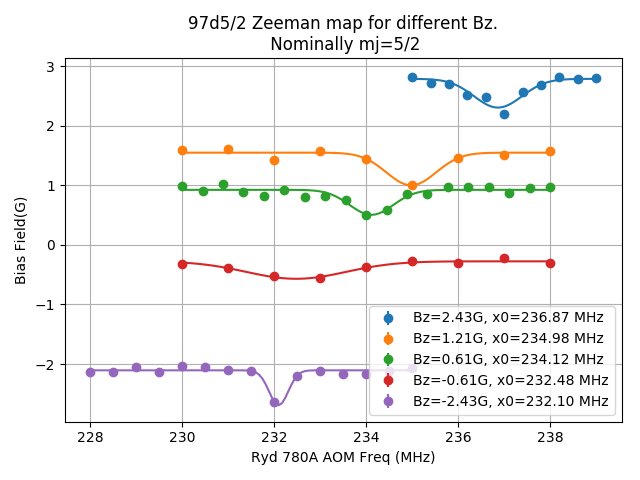

amplitude: -0.481406280706 , x0: 236.865802609, sigma:0.735227941304 
amplitude: -0.547728325096 , x0: 234.979724545, sigma:0.760410001481 
amplitude: -0.419303841907 , x0: 234.116120637, sigma:0.669889672142 
amplitude: -0.292846832705 , x0: 232.479056986, sigma:1.52877981594 
amplitude: -0.585327715611 , x0: 232.0982798, sigma:0.294775814573 


In [58]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
fig, ax = plt.subplots()
amount_for_offset=-0.5
for i in range(0,len(exp_ids)):
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()

    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fit_guesses=[-0.4, 233, 2 , 0.9]
    fitted_parameters=[]
    for roi in [2]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        yoffsetting=amount_for_offset*np.ones(len(reten))

        try:
            fit,pcov = curve_fit(gaussian,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
        except RuntimeError:
            error=1
        if error is not 1:
            print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
            xarray=np.linspace(np.min(data),np.max(data),100)
            yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])+Bz[i]+amount_for_offset
            plt.plot(xarray,yfit)
#             if roi==2:
#                 assorted_roi2freqs.append(fit[1])
        ax.errorbar(data,reten+Bz[i]+amount_for_offset,yerr=err,label="Bz={0:.2f}G, x0={1:.2f} MHz".format(Bz[i],fit[1]),fmt='o',color=colors[i])

ax.set_title('97d5/2 Zeeman map for different Bz.\n Nominally mj=5/2')
#ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('Bias Field(G)')
ax.grid()
ax.legend()
plt.tight_layout()
savefig=True
analysis_master_path='Y:/Analysis/'
exp_date="2018_04_25"
figure_path=analysis_master_path+exp_date+'/'
filename='20180425_Zeeman map'
if savefig:
    plt.savefig(figure_path+'{}.pdf'.format(filename))
    plt.savefig(figure_path+'{}.png'.format(filename))

In [37]:
Bz

array([-2.42875  , -1.214375 , -0.6071875,  0.6071875,  2.42875  ])